<a href="https://www.kaggle.com/code/tuankiennguyen/test-model-tumor-system?scriptVersionId=91274809" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install torchio

     |████████████████████████████████| 164 kB 889 kB/s            


In [2]:
import os
import torch
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
class GlobalConfig():
    root = '../input/brats20-dataset-training-validation'
    root_system = str(os.getcwd())
    train_path = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
    val_path = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'
    name_mapping_train = 'name_mapping.csv'
    survival_info_train = 'survival_info.csv'
    name_mapping_test = 'name_mapping_validation_data.csv'
    survival_info_test = 'survival_evaluation.csv'
    checkpoint = 'best_checkpoint/'
    best_checkpoint = 'best_checkpoint.pth'
    highest_checkpoint = 'highest_checkpoint.pth'
    train_df = 'train_df.csv'
    val_df = 'test_df.csv'
    pretrained_model_path = '../input/last-check-point/last_checkpoint.pth'
    seed = 55

class ProcessData():
    def SeedEveryThing(self, seed:int):
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)

    def PreprocessData(self, phase_: str='train'):
        """
        In this dataset of MICCAI_BraTS2020, it has two data files CSV so we need to
        merge them into one data frame to visualize and remove null data 
        """
        key = 'Brats20ID'
        config = GlobalConfig()
        if phase_ == 'train':
            path_ = config.train_path
            save_data_path = config.train_df
            name_mapping = config.name_mapping_train
            survival_info = config.survival_info_train
            name_feature = 'Brats20ID'
        else:
            path_ = config.val_path
            save_data_path = config.val_df
            name_mapping = config.name_mapping_test
            survival_info = config.survival_info_test
            name_feature = 'BraTS20ID'
        
        name_mapping = pd.read_csv(os.path.join(config.root, path_ + name_mapping))
        survival_info = pd.read_csv(os.path.join(config.root, path_ + survival_info))
        name_mapping.rename({'BraTS_2020_subject_ID': key}, axis = 1, inplace = True)
        survival_info.rename({name_feature: key}, axis = 1, inplace = True)
        df = survival_info.merge(name_mapping, on=key, how='right')
        path = []
        for _, row in df.iterrows():
            id_ = row[key]
            phase = id_.split('_')[-2]
            if phase == 'Training':
                data_path = os.path.join(config.root, path_ + id_)
            else:
                data_path = os.path.join(config.root, path_ + id_)
            path.append(data_path)
        df['Path'] = path
        df['Age_rank'] = df['Age'].values//10*10
        df= df.loc[df[key] != 'BraTS20_Training_355'].reset_index(drop = True)
        train_df = df.loc[df['Age'].isnull() != True].reset_index(drop = True)
        skf = StratifiedKFold(n_splits=7, random_state=config.seed, shuffle = True)
        for i, (train_index, val_index) in enumerate(skf.split(train_df, train_df['Age_rank'])):
            train_df.loc[val_index,['Fold']] = i
        train_df.to_csv(os.path.join(config.root_system, save_data_path), index = False) #Remove config.checkpoint
        test_df = df.loc[df['Age'].isnull() == True].reset_index(drop = True)
        test_df.to_csv(os.path.join(config.root_system, 'test_df.csv'), index = False)
# Test Done!
# if __name__ == '__main__':
#     config = GlobalConfig()
#     data = ProcessData()
#     test = data.PreprocessData('train')


In [3]:
import os
import sys
import torch
import torchio as tio
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
# from utils.InputDataProcess import GlobalConfig
import warnings
warnings.filterwarnings('ignore')
class BratsDataSet(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str = 'test'):
        self.df = df
        self.phase = phase
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, index):
        id_ = self.df.loc[index, 'Brats20ID']
        data_path = self.df.loc[self.df['Brats20ID'] == id_]['Path'].values[0]
        resample = tio.Resample((3,3,2.5))
        normalize = tio.ZNormalization()
        img = tio.ScalarImage(os.path.join(data_path, id_ + '_t1.nii')) # data_img shape (1, 240, 240, 155)
        img = resample(img) # data_img shape (1, 120, 120, 78)
#         img = normalize(img)
        img = np.array(img)
        img = np.squeeze(img, axis = 0)
        img = self.Normalize(img)
        img_stack = np.moveaxis(img, (0,1,2), (0,2,1))
        img_stack = torch.Tensor(img_stack)
        img_stack = torch.unsqueeze(img_stack, dim = 0)
        
        if self.phase != 'test':
            labels = tio.LabelMap(os.path.join(data_path, id_ + '_seg.nii'))
            labels = resample(labels)
            labels = np.array(labels)
            labels = np.squeeze(labels, axis = 0)
            label_stack = self.ConvertToMultiChannel(labels)
            label_stack = torch.Tensor(label_stack)
            label_stack = torch.unsqueeze(label_stack, dim = 0)
            subjects = tio.Subject(image = tio.ScalarImage(tensor = img_stack),
                                   label = tio.LabelMap(tensor = (label_stack > 0.5)),
                                   id = id_
                                  )
            return subjects
        subjects = tio.Subject(image = tio.ScalarImage(tensor = img_stack),
                               id = id_
                              )
        return subjects
    
    def Normalize(self, image : np.ndarray):
        return (image - np.min(image))/(np.max(image) - np.min(image))
 
    def ConvertToMultiChannel(self, labels):
        '''
        Convert labels to multi channels based on brats classes:
        label 1 is the peritumoral edema
        label 2 is the GD-enhancing tumor
        label 3 is the necrotic and non-enhancing tumor core
        The possible classes are TC (Tumor core), WT (Whole tumor)
        and ET (Enhancing tumor)
        '''
        label_WT = labels.copy()
        label_WT[label_WT == 1] = 1
        label_WT[label_WT == 2] = 1
        label_WT[label_WT == 4] = 1
        label_stack = np.moveaxis(label_WT, (0,1,2), (0,2,1))
        return label_stack
class GetData():
    # List transform
    def get_transform(self, phase):
        if phase == 'train':
            list_transforms = [
                tio.ToCanonical(p=0.25),
                tio.RandomAffine(p = 0.25),
                tio.RandomFlip(axes=['LR', 'AP', 'IS'], p = 0.25),          
            ]
            transform = tio.Compose(list_transforms)
        else:
            list_transforms = []
            transform = tio.Compose(list_transforms)
        return transform
    
    
    # Get DataLoader
    def get_dataloader(self, dataset, path_to_csv, phase, fold = 0, batch_size = 1, num_workers = 4):
        """
        This  function is saving image data in to the list and putting it with torchio.SubjectDataSet
        to split and transform image
        """
        data = pd.read_csv(path_to_csv)
        train_data = data.loc[data['Fold'] != fold].reset_index(drop = True)
        val_data = data.loc[data['Fold'] == fold].reset_index(drop = True)
        if phase == 'train':
            data = train_data
        elif phase == 'val':
            data = val_data
        data_set = dataset(data, phase)
        list_subjects = []
        for i in range(len(data_set)):
            list_subjects.append(data_set[i])
        subject_dataset = tio.SubjectsDataset(list_subjects, transform=self.get_transform(phase))
        patch_size = 60
        queue_length = 300
        sample_per_volume = 1
        sampler = tio.data.UniformSampler(patch_size)
        patches_queue = tio.Queue(
            subject_dataset,
            queue_length,
            sample_per_volume,
            sampler,
            num_workers=num_workers,
        )
        data_loader = DataLoader(patches_queue,
                                 batch_size = batch_size,
                                 num_workers=0,
                                 pin_memory=True,
                                )
        print('Finish Loading DataSet')
        return data_loader
# Test
# if __name__ == '__main__':
#     config = GlobalConfig()
#     getdata = GetData()
#     path_to_csv=os.path.join(config.root_system, config.train_df) #config.check_point
#     dataloader = getdata.get_dataloader(dataset=BratsDataSet, path_to_csv=path_to_csv, phase='valid', fold=0)


In [4]:
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class DiceLoss(nn.Module):
    def __init__(self, weight = None, size_average = True):
        super(DiceLoss, self).__init__()
    def forward(self, inputs, targets, smooth = 1):
        # Commnent out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)
        
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs*targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum()+ targets.sum() + smooth)
        return 1 - dice

def dice_coef_metric(inputs: torch.Tensor, target: torch.Tensor, threshold: float = 0.5, eps:float = 1e-9):
    """
    Calculate Dice score for data batch,
    Params:
        inputs: model outputs after activation function
        target: true values
        threshold: threshold for inputs
        eps: additive to refine the estimate
    Return: dice score 
    """
    score = []
    num = inputs.shape[0]
    predictions = (inputs >= threshold).float()
    assert(predictions.shape == target.shape)
    for i in range(num):
        predict = predictions[i]
        target_ = target[i]
        intersection = 2.0*(target_*predict).sum()
        union = target_.sum() + predict.sum()
        if target_.sum() == 0 and predict.sum() == 0:
            score.append(1.0)
        else:
            score.append((intersection + eps)/union)
    return np.mean(score)

def jaccard_coef_metric(inputs: torch.Tensor, target: torch.Tensor, threshold: float = 0.5, eps: float = 1e-9):
    scores = []
    num = inputs.shape[0]
    predictions = (inputs >= threshold).float()
    assert(predictions.shape == target.shape)
    for i in range(num):
        prediction = predictions[i]
        target_ = target[i]
        intersection = (prediction * target_).sum()
        union = (prediction.sum() + target_.sum()) - (intersection + eps)
        
        if target_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps)/union)
    return np.mean(scores)

class Scores:
    def __init__(self, threshold: float=0.5):
        self.threshold = threshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    def update(self, logits: torch.Tensor, target: torch.Tensor):
        inputs = torch.sigmoid(logits)
        dice = dice_coef_metric(inputs, target, self.threshold)
        iou = jaccard_coef_metric(inputs, target, self.threshold)
        
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    def get_metrics(self):
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

class BCEDiceLoss(nn.Module):
    def __init__(self, weight = None, size_average = True):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    def forward(self, inputs, targets, smooth = 1):
        assert(inputs.shape == targets.shape)
        dice_loss = self.dice(inputs, targets)
        bce_loss = self.bce(inputs, targets)
        return  dice_loss + bce_loss
    

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss


class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=0.5, beta=0.5):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky
    

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=0.7, beta=0.3, gamma=4/3):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky


In [5]:
import torch
import torch.nn as nn
from torch.nn.functional import pad, sigmoid, binary_cross_entropy
from torch.utils.data import DataLoader, Dataset
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        x = self.double_conv(x)
        return x
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        x = self.encoder(x)
        return x
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Make sure size data when you combine are the same size
        diffX = x2.size()[4] - x1.size()[4]
        diffY = x2.size()[3] - x1.size()[3]
        diffZ = x2.size()[2] - x1.size()[2]
        
        x1 = torch.nn.functional.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
class UpP(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels*3, out_channels)
    def forward(self, x1, x2, x3):
        x1 = self.up(x1)
        # Make sure size data when you combine are the same size
        diffX1 = x3.size()[4] - x1.size()[4]
        diffY1 = x3.size()[3] - x1.size()[3]
        diffZ1 = x3.size()[2] - x1.size()[2]
        
        diffX2 = x3.size()[4] - x2.size()[4]
        diffY2 = x3.size()[3] - x2.size()[3]
        diffZ2 = x3.size()[2] - x2.size()[2]
        
        x2 = torch.nn.functional.pad(x2, (diffX2 // 2, diffX2 - diffX2 // 2, diffY2 // 2, diffY2 - diffY2 // 2, diffZ2 // 2, diffZ2 - diffZ2 // 2))
        x1 = torch.nn.functional.pad(x1, (diffX1 // 2, diffX1 - diffX1 // 2, diffY1 // 2, diffY1 - diffY1 // 2, diffZ1 // 2, diffZ1 - diffZ1 // 2))
        x = torch.cat([x3, x2, x1], dim=1)
        return self.conv(x)
class UpPP(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels*4, out_channels)
    def forward(self, x1, x2, x3, x4):
        x1 = self.up(x1)
        # Make sure size data when you combine are the same size
        diffX1 = x4.size()[4] - x1.size()[4]
        diffY1 = x4.size()[3] - x1.size()[3]
        diffZ1 = x4.size()[2] - x1.size()[2]
        
        diffX2 = x4.size()[4] - x2.size()[4]
        diffY2 = x4.size()[3] - x2.size()[3]
        diffZ2 = x4.size()[2] - x2.size()[2]
        
        diffX3 = x4.size()[4] - x3.size()[4]
        diffY3 = x4.size()[3] - x3.size()[3]
        diffZ3 = x4.size()[2] - x3.size()[2]
        
        x3 = torch.nn.functional.pad(x3, (diffX3 // 2, diffX3 - diffX3 // 2, diffY3 // 2, diffY3 - diffY3 // 2, diffZ3 // 2, diffZ3 - diffZ3 // 2))
        x2 = torch.nn.functional.pad(x2, (diffX2 // 2, diffX2 - diffX2 // 2, diffY2 // 2, diffY2 - diffY2 // 2, diffZ2 // 2, diffZ2 - diffZ2 // 2))
        x1 = torch.nn.functional.pad(x1, (diffX1 // 2, diffX1 - diffX1 // 2, diffY1 // 2, diffY1 - diffY1 // 2, diffZ1 // 2, diffZ1 - diffZ1 // 2))
        x = torch.cat([x4, x3, x2, x1], dim=1)
        return self.conv(x)
class UpPPP(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels*5, out_channels)
    def forward(self, x1, x2, x3, x4, x5):
        x1 = self.up(x1)
        # Make sure size data when you combine are the same size
        diffX1 = x5.size()[4] - x1.size()[4]
        diffY1 = x5.size()[3] - x1.size()[3]
        diffZ1 = x5.size()[2] - x1.size()[2]
        
        diffX2 = x5.size()[4] - x2.size()[4]
        diffY2 = x5.size()[3] - x2.size()[3]
        diffZ2 = x5.size()[2] - x2.size()[2]
        
        diffX3 = x5.size()[4] - x3.size()[4]
        diffY3 = x5.size()[3] - x3.size()[3]
        diffZ3 = x5.size()[2] - x3.size()[2]
        
        diffX4 = x5.size()[4] - x4.size()[4]
        diffY4 = x5.size()[3] - x4.size()[3]
        diffZ4 = x5.size()[2] - x4.size()[2]
        
        x4 = torch.nn.functional.pad(x4, (diffX4 // 2, diffX4 - diffX4 // 2, diffY4 // 2, diffY4 - diffY4 // 2, diffZ4 // 2, diffZ4 - diffZ4 // 2))        
        x3 = torch.nn.functional.pad(x3, (diffX3 // 2, diffX3 - diffX3 // 2, diffY3 // 2, diffY3 - diffY3 // 2, diffZ3 // 2, diffZ3 - diffZ3 // 2))
        x2 = torch.nn.functional.pad(x2, (diffX2 // 2, diffX2 - diffX2 // 2, diffY2 // 2, diffY2 - diffY2 // 2, diffZ2 // 2, diffZ2 - diffZ2 // 2))
        x1 = torch.nn.functional.pad(x1, (diffX1 // 2, diffX1 - diffX1 // 2, diffY1 // 2, diffY1 - diffY1 // 2, diffZ1 // 2, diffZ1 - diffZ1 // 2))
        x = torch.cat([x5, x4, x3, x2, x1], dim=1)
        return self.conv(x)
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.out_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.out_conv(x)

In [6]:
import torch
import torch.nn as nn
from torch.nn.functional import pad, sigmoid, binary_cross_entropy
from torch.utils.data import DataLoader, Dataset
# from model.UNET3D_BLOCK import DoubleConv, Down, Up, UpP, UpPP, UpPPP, Out
class Unet3D(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_classes = n_classes
        
        self.double_conv = DoubleConv(self.in_channels, self.out_channels)
        # encoder downsamplers
        self.down_1 = Down(self.out_channels, self.out_channels*2)
        self.down_2 = Down(self.out_channels*2, self.out_channels*4)
        self.down_3 = Down(self.out_channels*4, self.out_channels*8)
        self.down_4 = Down(self.out_channels*8, self.out_channels*16)

        # decoder upsamplers
        self.up_4 = Up(self.out_channels*16, self.out_channels*8)
        self.up_3 = Up(self.out_channels*8, self.out_channels*4)
        self.up_2 = Up(self.out_channels*4, self.out_channels*2)
        self.up_1 = Up(self.out_channels*2, self.out_channels)

        # output
        self.out = Out(self.out_channels, self.n_classes)
        
        self.dropout = nn.Dropout3d(0.35)
    def forward(self, x):
        # Encoder
        en_1 = self.double_conv(x)
        en_2 = self.down_1(en_1)
        en_2 = self.dropout(en_2)
        en_3 = self.down_2(en_2)
        en_3 = self.dropout(en_3)
        en_4 = self.down_3(en_3)
        en_4 = self.dropout(en_4)
        en_5 = self.down_4(en_4)
        
        # Decoder
        de_4 = self.up_4(en_5, en_4)
        de_4 = self.dropout(de_4)
        de_3 = self.up_3(de_4, en_3)
        de_3 = self.dropout(de_3)
        de_2 = self.up_2(de_3, en_2)
        de_2 = self.dropout(de_2)
        de_1 = self.up_1(de_2, en_1)
        
        out = self.out(de_1)
        return out
class Unet3DPP(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_classes = n_classes
        
        self.x00 = DoubleConv(self.in_channels, self.out_channels)
        # UNet3D ++ L1
        self.down_to_x10 = Down(self.out_channels, self.out_channels*2)
        self.up_to_x01 = Up(self.out_channels*2, self.out_channels)
        # UNet3D ++ L2
        self.down_to_x20 = Down(self.out_channels*2, self.out_channels*4)
        self.up_to_x11 = Up(self.out_channels*4, self.out_channels*2)
        self.up_to_x02 = UpP(self.out_channels*2, self.out_channels)
        # UNet3D ++ L3
        self.down_to_x30 = Down(self.out_channels*4, self.out_channels*8)
        self.up_to_x21 = Up(self.out_channels*8, self.out_channels*4)
        self.up_to_x12 = UpP(self.out_channels*4, self.out_channels*2)
        self.up_to_x03 = UpPP(self.out_channels*2, self.out_channels)
        # UNet3D ++ L4
        self.down_to_x40 = Down(self.out_channels*8, self.out_channels*16)
        self.up_to_x31 = Up(self.out_channels*16, self.out_channels*8)
        self.up_to_x22 = UpP(self.out_channels*8, self.out_channels*4)
        self.up_to_x13 = UpPP(self.out_channels*4, self.out_channels*2)
        self.up_to_x04 = UpPPP(self.out_channels*2, self.out_channels)
        
        # output
        self.out = Out(self.out_channels, self.n_classes)
        
        self.dropout = nn.Dropout3d(0.25)
    def forward(self, x):
        x00 = self.x00(x)
        # UNet3D ++ L1
        x10 = self.down_to_x10(x00)
        x01 = self.up_to_x01(x10, x00)
        x01 = self.dropout(x01)
        # UNet3D ++ L2
        x20 = self.down_to_x20(x10)
        x11 = self.up_to_x11(x20, x10)
#         x11 = self.dropout(x11)
        x02 = self.up_to_x02(x11, x01, x00)
        x02 = self.dropout(x02)
        # UNet3D ++ L3
        x30 = self.down_to_x30(x20)
        x21 = self.up_to_x21(x30, x20)
#         x21 = self.dropout(x21)
        x12 = self.up_to_x12(x21, x11, x10)
#         x12 = self.dropout(x12)
        x03 = self.up_to_x03(x12, x02, x01, x00)
        x03 = self.dropout(x03)
        # UNet3D ++ L4
        x40 = self.down_to_x40(x30)
        x31 = self.up_to_x31(x40, x30)
#         x31 = self.dropout(x31)
        x22 = self.up_to_x22(x31, x21, x20)
#         x22 = self.dropout(x22)
        x13 = self.up_to_x13(x22, x12, x11, x10)
#         x13 = self.dropout(x13)
        x04 = self.up_to_x04(x13, x03, x02, x01, x00)
        x04 = self.dropout(x04)
        
        # Output
        out = self.out(x04)
        return out
# if __name__ == '__main__':
#     model = UNET3D(in_channels=1, out_channels=32, n_classes=1).to('cuda')
#     print(model.eval())

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import  Dataset
# from utils.DatasetProcess import GetData
# from utils.LossFunctions import Scores
# from utils.InputDataProcess import GlobalConfig
import torchio as tio
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
class Training:
    def __init__(self,
                 model: nn.Module,
                 dataset : Dataset,
                 criterion: nn.Module,
                 lr: float,
                 num_epochs: int,
                 batch_size: int,
                 path_to_csv: str,
                 fold: int,
                 accumulation_steps: int,
                 save_model_history: bool=True,
                 display_plot: bool= True
                ):
        # 1.Setup criterion and optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print('Training on', self.device)
        if torch.cuda.device_count() >= 1:
          print("Let's use", torch.cuda.device_count(), "GPUs!")
          self.model = nn.DataParallel(model).to(self.device)
        self.dataset = dataset
        self.criterion = criterion
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                                    mode='min',
                                                                    factor=0.75,
                                                                    patience= 5,
                                                                    verbose=True,
                                                                   )
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.accumulation_steps = accumulation_steps
        self.getdata = GetData()
        # 2. Setup dataset
        self.phases = ['train', 'val']
        self.dataloaders = {phase: self.getdata.get_dataloader(self.dataset,
                                                  path_to_csv=path_to_csv,
                                                  phase=phase,
                                                  fold=fold,
                                                  batch_size=self.batch_size,
                                                  num_workers=4
                                                 )for phase in self.phases}
        # 3. Setup loss and plot
        self.best_loss = float('inf')
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.save_model_history = save_model_history
        self.display_plot = display_plot
        self.config = GlobalConfig()
    def run(self):
        for epoch in range(self.num_epochs):
            self.one_epoch(epoch, 'train')
            with torch.no_grad():
                val_loss = self.one_epoch(epoch, 'val')
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print('Saved new checkpoint')
                self.best_loss = val_loss
                torch.save(self.model.state_dict(), os.path.join(self.config.root_system, 'best_checkpoint.pth'))#self.config.check_point +
            if self.dice_scores['val'][-1] >= 0.8 or self.iou_scores['val'][-1] >= 0.8:
                print('Saved highest checkpoint')
                torch.save(self.model.state_dict(), os.path.join(self.config.root_system, 'highest_checkpoint.pth'))#self.config.check_point +
            print('-------------------------------')
        if self.display_plot:
            self.plot_history()
        if self.save_model_history:
            self.save_history()
                
    def one_epoch(self, epoch: int, phase: str):
        print(f'{phase} epoch: {epoch}')
        self.model.train() if phase == 'train' else self.model.eval()
        scores = Scores()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for i, data in enumerate(dataloader):
            images = data['image'][tio.DATA].to(self.device)
            targets = data['label'][tio.DATA].to(self.device)
            predict = self.model(images)
            loss = self.criterion(predict, targets.float()) #.float()
            loss = loss/self.accumulation_steps
            if phase == 'train':
                loss.backward()
                if (i + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            scores.update(predict.detach().cpu(),
                          targets.detach().cpu()
                         )
        epoch_loss = (running_loss * self.accumulation_steps)/total_batches
        epoch_dice, epoch_iou = scores.get_metrics()
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.iou_scores[phase].append(epoch_iou)
        print(f'loss: {epoch_loss:.3f} dice: {epoch_dice:.3f} iou: {epoch_iou:.3f}')
        return epoch_loss
    
    def save_history(self):
        torch.save(self.model.state_dict(),os.path.join(self.config.root_system, 'last_checkpoint.pth'))#self.config.check_point +
        torch.save(self.model,os.path.join(self.config.root_system,  'model.pth'))#self.config.check_point +
        print('Saved check point')
        logs_ = [self.losses, self.dice_scores, self.iou_scores]
        log_name_ = ['_loss', '_dice', '_iou']
        logs = [logs_[i][key] for i in range(len(logs_)) for key in logs_[i]]
        log_names = [key + log_name_[i] for i in range(len(logs_)) for key in logs_[i]]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv(os.path.join(self.config.root_system, 'train_log.csv'), index=False)#self.config.check_point +
    
    def load_predtrain_model(self, pred_path:str):
        self.model.load_state_dict(torch.load(pred_path))
        print('Predtrain model loaded')
    
    def plot_history(self):
        data = [self.losses, self.dice_scores, self.iou_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.iou_scores['train'][-1]}
            val jaccard score {self.iou_scores['val'][-1]}
            """,
        ]
        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
            plt.tight_layout()
            plt.show()
    


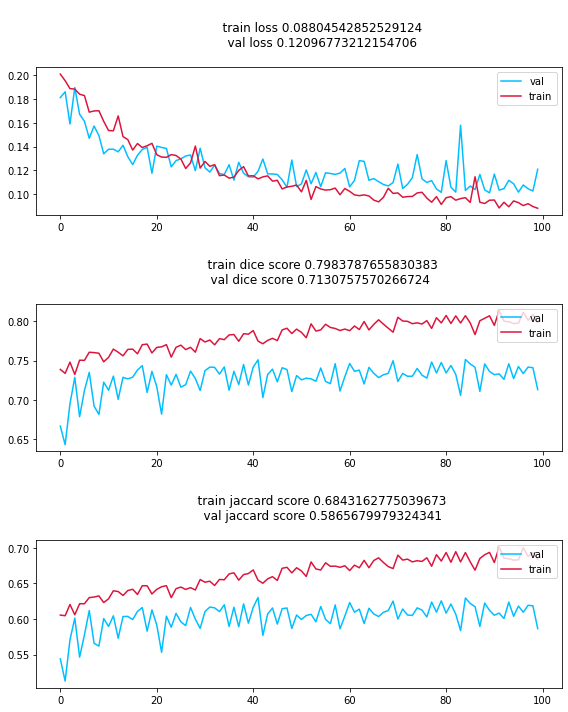

Saved check point


In [8]:
import os
import torch
import torch.nn as nn
# from model.UNET3D import Unet3D, Unet3DPP
# from utils.DatasetProcess import BratsDataSet
# from utils.LossFunctions import BCEDiceLoss, FocalTverskyLoss
# from utils.InputDataProcess import GlobalConfig, ProcessData
# from utils.TrainFunction import Training
if __name__ == '__main__':
    torch.cuda.empty_cache()
    config = GlobalConfig()
    data = ProcessData()
    train_data = data.PreprocessData('train')
    model_1 = Unet3D(in_channels=1, out_channels=32, n_classes=1)
    model_2 = Unet3DPP(in_channels=1, out_channels=64, n_classes=1)
    model = model_2
    dataset=BratsDataSet
    criterion=FocalTverskyLoss()
    lr=3e-4
    num_epochs=100
    batch_size = 4
    path_to_csv=os.path.join(config.root_system, config.train_df) #config.check_point
    fold=0
    accumulation_steps=10
    save_model_history=True
    display_plot=True
      
    trainer=Training(model=model,
                     dataset=dataset,
                     criterion=criterion,
                     lr=lr,
                     num_epochs=num_epochs,
                     batch_size=batch_size,
                     path_to_csv=path_to_csv,
                     fold=fold,
                     accumulation_steps=accumulation_steps,
                     save_model_history=save_model_history,
                     display_plot=display_plot)
    if config.pretrained_model_path is not None:
        trainer.load_predtrain_model(config.pretrained_model_path)
    trainer.run()

In [9]:
# import torch
# import torch.nn as nn
# from torch.utils.data import  Dataset
# import pytorch_lightning as pl
# from torch.nn.functional import pad, sigmoid, binary_cross_entropy
# from torch.utils.data import DataLoader, Dataset
# class Model(pl.LightningModule):
#   def __init__(self,in_channels,out_channels, n_classes, dataset : Dataset, learning_rate, batch_size: int, path_to_csv: str, fold: int):
#         super().__init__()
#         self.save_hyperparameters()
#         self.automatic_optimization = True
#         self.learning_rate = learning_rate
#         self.criterion = FocalTverskyLoss()
#         self.dataset = dataset
#         self.batch_size = batch_size
#         self.getdata = GetData()
#         self.phases = ['train', 'val']
#         self.dataloaders = {phase: self.getdata.get_dataloader(self.dataset,
#                                                   path_to_csv=path_to_csv,
#                                                   phase=phase,
#                                                   fold=fold,
#                                                   batch_size=self.batch_size,
#                                                   num_workers=4
#                                                  )for phase in self.phases}
#         self.dice_train = []
#         self.iou_train = []
#         self.dice_val = []
#         self.iou_val = []

#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.n_classes = n_classes
        
#         self.x00 = DoubleConv(self.in_channels, self.out_channels)
#         # UNet3D ++ L1
#         self.down_to_x10 = Down(self.out_channels, self.out_channels*2)
#         self.up_to_x01 = Up(self.out_channels*2, self.out_channels)
#         # UNet3D ++ L2
#         self.down_to_x20 = Down(self.out_channels*2, self.out_channels*4)
#         self.up_to_x11 = Up(self.out_channels*4, self.out_channels*2)
#         self.up_to_x02 = UpP(self.out_channels*2, self.out_channels)
#         # UNet3D ++ L3
#         self.down_to_x30 = Down(self.out_channels*4, self.out_channels*8)
#         self.up_to_x21 = Up(self.out_channels*8, self.out_channels*4)
#         self.up_to_x12 = UpP(self.out_channels*4, self.out_channels*2)
#         self.up_to_x03 = UpPP(self.out_channels*2, self.out_channels)
#         # UNet3D ++ L4
#         self.down_to_x40 = Down(self.out_channels*8, self.out_channels*16)
#         self.up_to_x31 = Up(self.out_channels*16, self.out_channels*8)
#         self.up_to_x22 = UpP(self.out_channels*8, self.out_channels*4)
#         self.up_to_x13 = UpPP(self.out_channels*4, self.out_channels*2)
#         self.up_to_x04 = UpPPP(self.out_channels*2, self.out_channels)
        
#         # output
#         self.out = Out(self.out_channels, self.n_classes)
        
#         self.dropout = nn.Dropout3d(0.25)
#   def forward(self, x):
#         x00 = self.x00(x)
#         # UNet3D ++ L1
#         x10 = self.down_to_x10(x00)
#         x01 = self.up_to_x01(x10, x00)
#         x01 = self.dropout(x01)
#         # UNet3D ++ L2
#         x20 = self.down_to_x20(x10)
#         x11 = self.up_to_x11(x20, x10)
#         x11 = self.dropout(x11)
#         x02 = self.up_to_x02(x11, x01, x00)
#         x02 = self.dropout(x02)
#         # UNet3D ++ L3
#         x30 = self.down_to_x30(x20)
#         x21 = self.up_to_x21(x30, x20)
#         x21 = self.dropout(x21)
#         x12 = self.up_to_x12(x21, x11, x10)
#         x12 = self.dropout(x12)
#         x03 = self.up_to_x03(x12, x02, x01, x00)
#         x03 = self.dropout(x03)
#         # UNet3D ++ L4
#         x40 = self.down_to_x40(x30)
#         x31 = self.up_to_x31(x40, x30)
#         x31 = self.dropout(x31)
#         x22 = self.up_to_x22(x31, x21, x20)
#         x22 = self.dropout(x22)
#         x13 = self.up_to_x13(x22, x12, x11, x10)
#         x13 = self.dropout(x13)
#         x04 = self.up_to_x04(x13, x03, x02, x01, x00)
#         x04 = self.dropout(x04)
        
#         # Output
#         out = self.out(x04)
#         return out
#   def train_dataloader(self):
#         return self.dataloaders['train']
#   def val_dataloader(self):
#         return self.dataloaders['val']
#   def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)                                                           
#         schedulers = {"scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.75,patience= 5,verbose=True,), "monitor": "val_loss"}
#         return [optimizer], [schedulers]
#   def training_step(self, train_batch, batch_idx):
#         images = train_batch['image'][tio.DATA]
#         targets = train_batch['label'][tio.DATA]
#         predict = self.forward(images)
#         loss = self.criterion(predict, targets)
#         scores = Scores()
#         scores.update(predict.detach().cpu(),
#                           targets.detach().cpu()
#                          )
#         epoch_dice, epoch_iou = scores.get_metrics()
#         # log values
#         self.dice_train.append(epoch_dice)
#         self.iou_train.append(epoch_iou)
#         dice_scores = np.mean(self.dice_train)
#         iou_scores = np.mean(self.iou_train)
#         self.log('dice_train', dice_scores)
#         self.log('iou_train', iou_scores)
#         self.log('train_loss', loss)
#         return loss
#   def validation_step(self, val_batch, batch_idx):
#         images = val_batch['image'][tio.DATA]
#         targets = val_batch['label'][tio.DATA]
#         predict = self.forward(images)
#         loss = self.criterion(predict, targets)
#         scores = Scores()
#         scores.update(predict.detach().cpu(),
#                           targets.detach().cpu()
#                          )
#         epoch_dice, epoch_iou = scores.get_metrics()
#         self.dice_val.append(epoch_dice)
#         self.iou_val.append(epoch_iou)
#         dice_scores = np.mean(self.dice_val)
#         iou_scores = np.mean(self.iou_val)
#         # log values
#         self.log('dice_val', dice_scores)
#         self.log('iou_val', iou_scores)
#         self.log('val_loss', loss)
#         print(f'Val loss: {loss},Dice scores: {dice_scores}, lr: {self.learning_rate}')
#         return loss

In [10]:
# torch.cuda.empty_cache()
# from pytorch_lightning.utilities.distributed import tpu_distributed
# import pytorch_lightning as pl
# from pytorch_lightning.callbacks import EarlyStopping
# from pytorch_lightning import Trainer
# from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
# # Import model

# config = GlobalConfig()
# data = ProcessData()
# train_data = data.PreprocessData('train')
# # model_1 = Unet3D(in_channels=1, out_channels=32, n_classes=1)
# dataset=BratsDataSet
# criterion=FocalTverskyLoss()
# path_to_csv=os.path.join(config.root_system, config.train_df) #config.check_point
# fold=0
# unet = Unet3DPP(in_channels=1,out_channels=32,n_classes=1)
# model = Model(in_channels=1,out_channels=56,n_classes=1,
#               dataset=BratsDataSet,
#               learning_rate=2.5e-4,
#               batch_size=5,
#               path_to_csv=path_to_csv,
#               fold=0)
# checkpoint_callback = ModelCheckpoint(
#         dirpath=os.path.join(config.root_system), #config.check_point +
#         filename = 'checkpoint-epoch{epoch:02d}',
#         mode='max',
#         auto_insert_metric_name=True,
#         save_on_train_epoch_end=True,
#         verbose=True,
#     )
# stop_callback = EarlyStopping(
#         monitor='dice_val',
#         mode='max',
#         patience=10,
#         verbose=True,
#     )
# # Init trainer
# trainer = pl.Trainer(gpus=1,
#                      check_val_every_n_epoch=1,
#                      max_epochs = 150,
#                      checkpoint_callback=checkpoint_callback,
#                      callbacks=stop_callback,)
# # Tune to find the learning rates
# # trainer.tune(model)
# # model.learning_rate
# trainer.fit(model)

In [11]:
# from model.UNET3D import Unet3D, Unet3DPP
# from utils.DatasetProcess import BratsDataSet
# from utils.LossFunctions import BCEDiceLoss, FocalTverskyLoss
# from utils.InputDataProcess import GlobalConfig, ProcessData
# from utils.TrainFunction import Training
class SegmentationImage():
    def __init__(self):
        self.model_1 = Unet3DPP(in_channels=1, out_channels=32, n_classes=1)
        self.model_2 = Unet3DPP(in_channels=1, out_channels=32, n_classes=1)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    def PredictImage(self, images: tio.ScalarImage):
        torch.cuda.empty_cache()
        if os.path.join(self.config.root_system, config.highest_checkpoint) is not None:
            load_checkpoint = os.path.join(self.config.root_system, config.higest_checkpoint) #config.checkpoint
        elif os.path.join(self.config.root_system, config.best_checkpoint) is not None:
            load_checkpoint = os.path.join(self.config.root_system, config.best_checkpoint) #config.checkpoint
        model = nn.DataParallel(self.model_1).to(self.device)
        model.load_state_dict(torch.load(load_checkpoint))
        with torch.no_grad():
            img = images[tio.DATA].to(self.device)
            predict = self.model(img)
            self.ShowPredict(images, predict)
        return predict
    def VolumeCalculation(self, predict: numpy.array):
        volume = 0
        for z in range(predict.shape[2]): 
            _, thresh = cv2.threshold(predict[:,:,z], 0, 1, cv2.THRESH_BINARY)
            output = cv2.connectedComponentsWithStats(thersh, 8, cv2.CV_32S)
            numLabels, Labels, Stats, Centroids = output
            for i in range(1, numLabels):
                area = stats[i, cv2.CC_STAT_AREA]
                volume += area
        return volume
    def FindCenterImageTumor(self, predict: numpy.array, x: int):
        a_top = 0
        a_bottom = 0
        if x == 2:
            predict_a = np.array(predict[:,:,a], np.float32)
        elif x == 1:
            predict_a = np.array(predict[:,a,:], np.float32)
        else:
            predict_a = np.array(predict[a,:,:], np.float32)
        for a in range(predict.shape[x]):
            a_top += 1
            mean_predict = np.mean(predict_a)
            if mean_predict > 0:
                break
        for a in range(predict.shape[x], -1):
            a_bottom += 1
            mean_predict = np.mean(predict_a)
            if mean_predict > 0:
                break
        a_center = np.around((a_bottom - a_top)/2)
        if x == 2:
            image_center = predict[:,:,a_center]
        elif x == 1:
            image_center = predict[:,a_center,:]
        else:
            image_center = predict[a_center,:,:]
        _, thresh = cv2.threshold(image_center, 0, 1, cv2.THRESH_BINARY)
        mask = np.zeros(thresh.shape, np.uint8)
        output = cv2.connectedComponentsWithStats(thersh, 8, cv2.CV_32S)
        numLabels, Labels, Stats, Centroids = output
        for i in range(1, numLabels):
            x = stats[i, cv2.CC_STAT_TOP]
            y = stats[i, cv2.CC_STAT_LEFT]
            w = stats[i, cv2.CC_STAT_WEIGHT]
            h = stats[i, cv2.CC_STAT_HIGH]
            center_tumor = (int(x+w/2), int(y+h/2))
        return center_tumor
    
    def ShowPredict(self,image:tio.ScalarImage, predict:numpy.array):
        img_tensor = data['image'][tio.DATA].squeeze().cpu().detach().numpy() 
        predict_tensor = predict.squeeze().squeeze().cpu().detach().numpy()
        image = np.rot90(montage(img_tensor))
        mask_predict = np.rot90(montage(predict_tensor))
        fig, ax = plt.subplots(1, 1, figsize = (20, 20))
        ax.imshow(image, cmap ='gray')
        ax.imshow(np.ma.masked_where(mask == False, mask_predict),
        cmap='cool', alpha=0.6)
        